In [20]:
import os
import sys
sys.path.append("..")
import h5py
import json
import random
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from array import *
from natsort import natsorted

In [22]:
#%%timeit
def dataset_cutoff(dataset_dr,target_length=40):
    new_dataset = []
    new_dataset_y = []
    data_files = os.listdir(dataset_dr)
    for f in data_files:
        if f[0] == '.':
                continue
        
        data_ = np.load(dataset_dr+f)
        l = data_.shape[0]
        label = int(f.split('.')[0].split('_')[0])
        data_x = range(l)
        if l<target_length:
            N = int(target_length//l)+1
            data_idx = np.tile(data_x,N)[:target_length]
            new_dataset.append(data_[data_idx,:])
            new_dataset_y.append(label)
        else: 
            N = int(l//target_length)+1
            for i in range(N): 
                if i==N-1: 
                    data_idx = data_x[-target_length:]
                    new_dataset.append(data_[data_idx,:])
                    new_dataset_y.append(label)
                else: 
                    data_idx = data_x[i*target_length:(i+1)*target_length]
                    new_dataset.append(data_[data_idx,:])
                    new_dataset_y.append(label)
                    
    print('dataset shape: ',np.array(new_dataset).shape,np.array(new_dataset_y).shape)
    return np.array(new_dataset),np.array(new_dataset_y)
    
new_test_dataset_x,new_test_dataset_y = dataset_cutoff('./data/npy_data/test/')

new_train_dataset_x,new_train_dataset_y = dataset_cutoff('./data/npy_data/train/')

new_eval_dataset_x,new_eval_dataset_y = dataset_cutoff('./data/npy_data/eval/')
    

dataset shape:  (5600, 40, 32, 32) (5600,)
dataset shape:  (2893, 40, 32, 32) (2893,)
dataset shape:  (2849, 40, 32, 32) (2849,)


In [24]:
np.save('./data/data_set/test_x2.npy', new_test_dataset_x[:2893])
# np.save('./data_set/test_x2.npy', new_test_dataset_x[2800:])
np.save('./data/data_set/test_y2.npy', new_test_dataset_y[:2893])
# np.save('./data_set/test_y2.npy', new_test_dataset_y[2800:])

# np.save('./data/data_set/train_x.npy', new_train_dataset_x)
# np.save('./data/data_set/train_y.npy', new_train_dataset_y)

# np.save('./data/data_set/valid_x.npy', new_eval_dataset_x)
# np.save('./data/data_set/valid_y.npy', new_eval_dataset_y)

## Model 

In [7]:
%reset

In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import matplotlib
from torch.utils import data

In [49]:
seq_length = 40
batch_size =32
train_x = np.load('./data/data_set/train_x.npy')/255.
train_y = np.load('./data/data_set/train_y.npy')
# plt.hist(train_y)

valid_x = np.load('./data/data_set/valid_x.npy')/255.
valid_y = np.load('./data/data_set/valid_y.npy')

test_x = np.load('./data/data_set/test_x.npy')/255.
test_y = np.load('./data/data_set/test_y.npy')

In [51]:
len(train_x.ravel())

118497280

In [36]:
train_x = train_x[:100]
train_y = train_y[:100]

In [37]:
# remove the background images
idx_not_11 = np.where(test_y<11)[0]
test_x = test_x[idx_not_11,:,:,:]
test_y = test_y[idx_not_11]

_,seq_length,dim_row,dim_col = train_x.shape
print('input dataset shap: ',train_x.shape)
print('output dataset shap: ',train_y.shape)

def get_DataLoader(train_x,train_y,batch_size=200,is_binary=False):
    train_y = np.tile(train_y,seq_length).reshape(seq_length,len(train_y)).T
    if is_binary:
        train_dataset = data.TensorDataset(torch.Tensor((train_x>0)*1.), torch.Tensor(train_y))
    else:
        train_dataset = data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

train_loader = get_DataLoader(train_x,train_y,batch_size=batch_size)
test_loader = get_DataLoader(test_x,test_y,batch_size=batch_size)
valid_loader = get_DataLoader(valid_x,valid_y,batch_size=batch_size)

input dataset shap:  (100, 40, 32, 32)
output dataset shap:  (100,)


In [38]:
torch.manual_seed(40)
thresh = 0.5  # neuronal threshold
b_j0 = 0.1  # neural threshold baseline
R_m = 1  # membrane resistance
lens = 0.5
gamma = 0.5

In [44]:
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply


def mem_update_adp(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
    isCuda = torch.cuda.is_available()
    if isCuda:
        alpha = torch.exp(-1. * dt / tau_m).cuda()
        ro = torch.exp(-1. * dt / tau_adp).cuda()
    else:
        alpha = torch.exp(-1. * dt / tau_m)
        ro = torch.exp(-1. * dt / tau_adp)
    if isAdapt:
        beta = 1.84
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b

def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    alpha = torch.exp(-1. * dt / tau_m)
    mem = mem *alpha +  (1-alpha)*inputs
    return mem

In [45]:
class RNN_s(nn.Module):
    def __init__(self, sub_seq_length,criterion):
        super(RNN_s, self).__init__()
        self.criterion = criterion
        self.sub_seq_length = sub_seq_length
        
        self.n = 256
        self.dense_i = nn.Linear(1024,self.n)
        self.dense_i2r = nn.Linear(self.n,self.n)
        self.dense_r = nn.Linear(self.n,self.n)
        self.dense_o = nn.Linear(self.n,11)
        
        self.tau_adp_i = nn.Parameter(torch.Tensor(self.n))
        self.tau_adp_r = nn.Parameter(torch.Tensor(self.n))
        self.tau_adp_o = nn.Parameter(torch.Tensor(11))
        
        self.tau_m_i = nn.Parameter(torch.Tensor(self.n))
        self.tau_m_r = nn.Parameter(torch.Tensor(self.n))
        self.tau_m_o = nn.Parameter(torch.Tensor(11))
        
        nn.init.normal_(self.tau_adp_i,20,5)
        nn.init.normal_(self.tau_adp_r,20,5)
        nn.init.normal_(self.tau_adp_o,20,5)
        
        nn.init.normal_(self.tau_m_i,20,5)
        nn.init.normal_(self.tau_m_r,20,5)
        nn.init.normal_(self.tau_m_o,3,1)
        

        
        self.b_h = self.b_o = b_j0

    def forward(self, input,labels=None,sub_length =5,output_type='integrator'):
        b,s,l = input.shape
        if torch.cuda.is_available():
            mem_layer1 = spike_layer1 = mem_layer2 = spike_layer2 = torch.rand(b, self.n).cuda()
            mem_layer3 = spike_layer3 = mem_output = torch.rand(b, 11).cuda()
            self.b_i = self.b_o=self.b_r = b_j0
            output = torch.zeros(b, 11).cuda()
        else:
            mem_layer1 = spike_layer1 = mem_layer2 = spike_layer2 = torch.rand(b, self.n)
            mem_layer3 = spike_layer3 = mem_output = torch.rand(b, 11)
            self.b_i = self.b_o=self.b_r = b_j0
            output = torch.zeros(b, 11)
        loss = 0
        predictions = []
        fr = []
        for i in range(s):
            input_x=input[:,i,:]
            d1_output = self.dense_i(input_x)
            mem_layer1, spike_layer1, theta_i, self.b_i = mem_update_adp(d1_output, mem_layer1, spike_layer1, self.tau_adp_i, self.b_i,self.tau_m_i)
            r_input = self.dense_i2r(spike_layer1)+self.dense_r(spike_layer2)
            mem_layer2, spike_layer2, theta_r, self.b_r = mem_update_adp(r_input, mem_layer2, spike_layer2, self.tau_adp_r, self.b_r,self.tau_m_r)
            o_input = self.dense_o(spike_layer2)
            if output_type == 'adp-mem':
                mem_layer3, spike_layer3, theta_o, self.b_o = mem_update_adp(o_input, mem_layer3, spike_layer3, self.tau_adp_o, self.b_o,self.tau_m_o)
            elif output_type == 'integrator':
                mem_layer3 = output_Neuron(o_input, mem_layer3, self.tau_m_o)
            
            output = F.log_softmax(mem_layer3,dim=-1)#
            
            # output_  = F.log_softmax(output,dim=1)
            predictions.append(output.data.cpu().numpy())
            if labels is not None:
                loss += self.criterion(output, labels[:, i])
            
            fr.append((spike_layer1.detach().mean().cpu().numpy()+spike_layer2.detach().mean().cpu().numpy())/2.)

        predictions = torch.tensor(predictions)
        return predictions, loss,np.mean(fr)

    def predict(self,input):
        prediction, _= self.forward(input)
        return prediction

In [46]:
def test(data_loader,after_num_frames=0):
    test_acc = 0.
    sum_samples = 0
    fr_list = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.view(-1, seq_length, 1024).to(device)
        labels = labels.view((-1,seq_length)).long().to(device)
        predictions, _,fr = model(images)
        _, predicted = torch.max(predictions.data, 2)
        labels = labels.cpu()
        predicted = predicted.cpu().t()
        fr_list.append(fr)
        
        test_acc += (predicted[:,after_num_frames:] == labels[:,after_num_frames:]).sum()
        
        sum_samples = sum_samples + predicted.numel()
    print('Mean FR: ',np.mean(fr_list))
    return test_acc.data.cpu().numpy() / sum_samples

def test_frame(data_loader,after_num_frames=0):
    test_acc = 0.
    sum_samples = 0
    test_acc_classes = np.zeros((11,40))
    test_acc_count = np.zeros((11,1))                                       
    fr_list = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.view(-1, seq_length, 1024).to(device)
        labels = labels.view((-1,seq_length)).long().to(device)
        predictions, _,fr = model(images)
        _, predicted = torch.max(predictions.data, 2)
        labels = labels.cpu()
        predicted = predicted.cpu().t()
        fr_list.append(fr)
        
        test_acc += (predicted[:,after_num_frames:] == labels[:,after_num_frames:]).float().mean(axis=0)
        f_test = predicted[:,after_num_frames:] == labels[:,after_num_frames:]
        for i in range(f_test.shape[0]):
            tmp = labels[i,0]
            test_acc_classes[tmp] += f_test[i].float().cpu().numpy()
            test_acc_count[tmp] += 1
        if i==1:
            print(f_test.shape)
        
        sum_samples = sum_samples + predicted.numel()
    print('Mean FR: ',np.mean(fr_list))

    return test_acc.data.cpu().numpy() / i,test_acc_classes/test_acc_count

In [47]:
def train(model,loader,optimizer,scheduler=None,num_epochs=10):
    best_acc = 0
    path = 'model/'  # .pth'
    acc_list=[]
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss_sum = 0
        sum_samples = 0
        fr_list = []
        for i, (images, labels) in enumerate(loader):
            images = images.view(-1, seq_length, 1024).requires_grad_().to(device)#images.view(-1, num_samples, input_dim).requires_grad_().to(device)
            labels = labels.view((-1,seq_length)).long().to(device)
            optimizer.zero_grad()
            
            predictions, train_loss,fr_ = model(images, labels)
            _, predicted = torch.max(predictions.data, 2)
            
            train_loss.backward(retain_graph=True)
            train_loss_sum += train_loss
            fr_list.append(fr_)
            optimizer.step()

            labels = labels.cpu()
            predicted = predicted.cpu().t()
            train_acc += (predicted == labels).sum()
            sum_samples = sum_samples + predicted.numel()
    
        if scheduler is not None:
            scheduler.step()
            
        train_acc = train_acc.data.cpu().numpy() / sum_samples
        valid_acc = test(valid_loader)
        
        if valid_acc>best_acc and train_acc>0.80:
            best_acc = valid_acc
            torch.save(model, path+str(best_acc)[:5]+'-frame-v3-inte.pth')

        acc_list.append(train_acc)
        print('epoch: {:3d}, Train Loss: {:.4f}, Train Acc: {:.4f},Valid Acc: {:.4f},fr: {:.4f}'.format(epoch,
                                                                           train_loss_sum.item()/len(loader)/(seq_length),
                                                                           train_acc,valid_acc,np.mean(fr_list)), flush=True)
    return acc_list

device: cpu
Mean FR:  0.031381039089626736
epoch:   0, Train Loss: 2.3528, Train Acc: 0.1273,Valid Acc: 0.1004,fr: 0.0159
Mean FR:  0.05517330593532987
epoch:   1, Train Loss: 2.3059, Train Acc: 0.1790,Valid Acc: 0.1041,fr: 0.0438
Mean FR:  0.04697219848632812
epoch:   2, Train Loss: 2.3449, Train Acc: 0.1995,Valid Acc: 0.1004,fr: 0.0527
Mean FR:  0.0358946058485243
epoch:   3, Train Loss: 2.2249, Train Acc: 0.1978,Valid Acc: 0.1027,fr: 0.0423
Mean FR:  0.03408940633138021
epoch:   4, Train Loss: 2.2172, Train Acc: 0.2087,Valid Acc: 0.1522,fr: 0.0341
Mean FR:  0.03528873019748264
epoch:   5, Train Loss: 1.9610, Train Acc: 0.2792,Valid Acc: 0.1875,fr: 0.0395
Mean FR:  0.03788011338975695
epoch:   6, Train Loss: 1.9264, Train Acc: 0.3297,Valid Acc: 0.1869,fr: 0.0414
Mean FR:  0.04067774454752604
epoch:   7, Train Loss: 1.8280, Train Acc: 0.3387,Valid Acc: 0.1918,fr: 0.0423
Mean FR:  0.0443094719780816
epoch:   8, Train Loss: 1.8876, Train Acc: 0.3340,Valid Acc: 0.1796,fr: 0.0504
Mean FR:

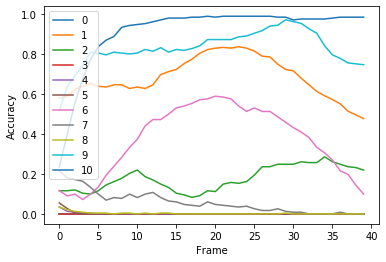

In [53]:
num_epochs = 15
sub_seq_length = 10
criterion = nn.NLLLoss()#nn.CrossEntropyLoss()
model = RNN_s(sub_seq_length=sub_seq_length,criterion=criterion)
# model.load('./model/796-mem.pth')
# model.load_state_dict(torch.load('./model/0.766-frame.pth'))
# model = torch.load('./model/0.833-frame-v3-inte.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model.to(device)

learning_rate =1.5e-2#1e-2

base_params = [model.dense_i.weight, model.dense_i.bias, 
               model.dense_o.weight, model.dense_o.bias,
               model.dense_r.weight, model.dense_r.bias, 
               model.dense_i2r.weight, model.dense_i2r.bias]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_adp_i, 'lr': learning_rate * 5},
    {'params': model.tau_adp_r, 'lr': learning_rate * 5},
    {'params': model.tau_adp_o, 'lr': learning_rate * 5},
    {'params': model.tau_m_i, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_r, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_o, 'lr': learning_rate * 2.5}],
    lr=learning_rate)


scheduler = StepLR(optimizer, step_size=30, gamma=.5) 

# training network

# with sechdual
train_acc_list = train(model,train_loader,optimizer,scheduler,num_epochs=num_epochs)
test_acc = test(test_loader)
print(test_acc)

test_acc = test(test_loader,10)
print(test_acc/30*40.)

test_acc = test(test_loader,35)
print(test_acc/20.*40.)

test_acc,test_acc_classes = test_frame(test_loader)
print(test_acc)
print(test_acc_classes.shape)

for i in range(11):
    plt.plot(test_acc_classes[i],label=str(i))
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Accuracy')
plt.show()